In [146]:
import warnings
warnings.filterwarnings('ignore')

import requests
import datetime
import time
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thredds_crawler.crawl import Crawl
import statsmodels.api as sm

Provide username and credentials and inputs.

In [130]:
USERNAME = ''
TOKEN = ''
REFDES = 'RS03AXBS-LJ03A-12-CTDPFB301'
STREAM = 'ctdpf_optode_sample'

Request asset information for reference.

In [131]:
DEPLOYEMENT_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12587/events/deployment/inv/'

asset_request_url = DEPLOYEMENT_URL+\
                     REFDES[:8] + '/'+\
                     REFDES[9:14] + '/'+\
                     REFDES[15:] + '/-1'
    
r = requests.get(asset_request_url, auth=(USERNAME, TOKEN))
asset_info = r.json()

ref_des_list = []
start_time_list = []
end_time_list = []
deployment_list = []
uid_list = []

for i in range(len(asset_info)):
    refdes = asset_info[i]['referenceDesignator']
    ref_des_list.append(refdes)

    deployment = asset_info[i]['deploymentNumber']
    deployment_list.append(deployment)

    start = asset_info[i]['eventStartTime']
    end = asset_info[i]['eventStopTime']

    uid = asset_info[i]['sensor']['calibration'][0]['calData'][0]['assetUid']
    uid_list.append(uid)

    try:
        start_time = datetime.datetime.utcfromtimestamp(start/1000.0)
        start_time_list.append(start_time)

        end_time = datetime.datetime.utcfromtimestamp(end/1000.0)
        end_time_list.append(end_time)

    except:
        end_time = datetime.datetime.utcnow()
        end_time_list.append(end_time)

data_dict = {
    'refdes':ref_des_list,
    'deployment':deployment_list,
    'start_time':start_time_list,
    'end_time':end_time_list,
    'uid':uid_list}
deployment_data = pd.DataFrame(data_dict, columns = ['refdes', 'deployment','start_time', 'end_time', 'uid'])

deployment_data

,refdes,deployment,start_time,end_time,uid
0,RS03AXBS-LJ03A-12-CTDPFB301,1,2014-08-07 17:45:00,2015-06-13 00:00:00.000000,ATAPL-67627-00003
1,RS03AXBS-LJ03A-12-CTDPFB301,2,2015-07-13 05:43:00,2016-07-11 00:00:00.000000,ATAPL-67627-00005
2,RS03AXBS-LJ03A-12-CTDPFB301,3,2016-07-12 00:00:00,2017-07-31 01:00:00.000000,ATAPL-67627-00003
3,RS03AXBS-LJ03A-12-CTDPFB301,4,2017-07-31 22:30:00,2017-12-18 21:31:33.403907,ATAPL-67627-00005


This instrument is affected during deployment 2.  
Set data request BEGIN to end_time - 1 month of the preceeding "good" deployment and END to start_time + 1 month from the affected deployment.

In [132]:
BEGIN = '2015-05-13'
END = '2015-08-13'

Request data.

In [133]:
%%time

DATA_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

data_request_url = DATA_URL+\
                     REFDES[:8] + '/'+\
                     REFDES[9:14] + '/'+\
                     REFDES[15:] + '/'+\
                    'streamed/' +\
                     STREAM +'?'+\
                    'beginDT='+ BEGIN +'T01:00:01.000Z&'+\
                    'endDT='+ END +'T01:00:01.000Z'

# this sends the request
r = requests.get(data_request_url, auth=(USERNAME, TOKEN))
data = r.json()

# this checks the thredds directory for the request to have been completed.
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1200): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

# this grabs the first and second url. first url is latter deployement and second url the former.  
url = data['allURLs'][0]
url = url.replace('.html', '.xml')
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
c = Crawl(url, select=[".*\.nc$"], debug=False)
datasets = [os.path.join(tds_url, x.id) for x in c.datasets]
splitter = url.split('/')[-2].split('-')

# put urls in chronological order
dataset_url_1 = datasets[0] 
dataset_url_0 = datasets[1]

print(dataset_url_0)
print(dataset_url_1)

request completed
https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20171218T213137-RS03AXBS-LJ03A-12-CTDPFB301-streamed-ctdpf_optode_sample/deployment0001_RS03AXBS-LJ03A-12-CTDPFB301-streamed-ctdpf_optode_sample_20150513T010001.218172-20150612T235959.144016.nc
https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20171218T213137-RS03AXBS-LJ03A-12-CTDPFB301-streamed-ctdpf_optode_sample/deployment0002_RS03AXBS-LJ03A-12-CTDPFB301-streamed-ctdpf_optode_sample_20150714T231829.456712-20150813T010000.781519.nc
CPU times: user 1.05 s, sys: 113 ms, total: 1.17 s
Wall time: 1min 4s


Open NetCDF and read pressure data into pandas dataframe.

In [151]:
d0_ds = xr.open_dataset(dataset_url_0)
d0_ds = d0_ds.swap_dims({'obs': 'time'})
d0_df = d0_ds['seawater_pressure'].to_dataframe()
del d0_df.index.name
d0_df = d0_df['seawater_pressure']

d1_ds = xr.open_dataset(dataset_url_1)
d1_ds = d1_ds.swap_dims({'obs': 'time'})
d1_df = d1_ds['seawater_pressure'].to_dataframe()
del d1_df.index.name
d1_df = d1_df['seawater_pressure']

Plot "good" deployment.

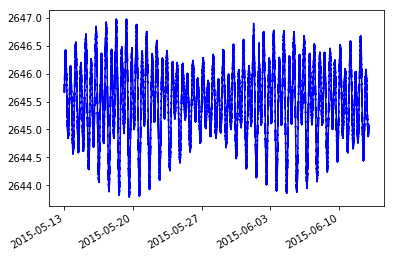

In [152]:
d0_df.plot(color='blue')
plt.show()

Plot "bad" deployment.

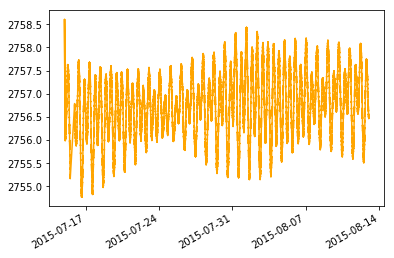

In [153]:
d1_df.plot(color='orange')
plt.show()

Show offset.

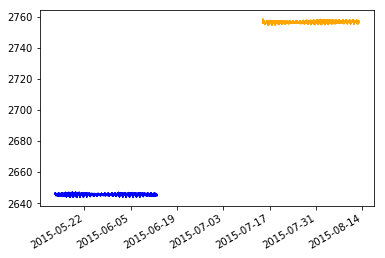

In [154]:
d0_df.plot(color='blue')
d1_df.plot(color='orange')
plt.show()

Print mean value for each deployment and mean offset.

In [138]:
print "good", d0_df.mean()
print "bad", d1_df.mean()
print "mean offset", d0_df.mean() - d1_df.mean()

good 2645.5017326
bad 2756.75827509
mean offset -111.256542497


Smooth data by resampling to minutely mean values.

In [139]:
d0_df_m = d0_df.resample('T').mean()
d0_df_m = d0_df_m.dropna()
d0_df_m = d0_df_m.to_frame()
d0_df_m['jdate'] = d0_df_m.index.to_julian_date()

d1_df_m = d1_df.resample('T').mean()
d1_df_m = d1_df_m.dropna()
d1_df_m = d1_df_m.to_frame()
d1_df_m['jdate'] = d1_df_m.index.to_julian_date()

Calculate linear regression line and predicted value at begin of "bad" deployement.

In [140]:
olsmod_d0_df_m = sm.OLS(d0_df_m['seawater_pressure'], d0_df_m['jdate'])
olsres_d0_df_m = olsmod_d0_df_m.fit()
ypred_d0_df_m = olsres_d0_df_m.predict(d1_df_m['jdate'].min())

olsmod_d1_df_m = sm.OLS(d1_df_m['seawater_pressure'], d1_df_m['jdate'])
olsres_d1_df_m = olsmod_d1_df_m.fit()
ypred_d1_df_m = olsres_d1_df_m.predict(d1_df_m['jdate'].min())

Print predicted value at begin of bad deployment for each deployment regression, along with offset. 

In [141]:
print "good", ypred_d0_df_m[0]
print "bad", ypred_d1_df_m[0]
print "predicted offset", ypred_d0_df_m[0] - ypred_d1_df_m[0]

good 2645.55281697
bad 2756.74174047
predicted offset -111.188923499


Compare results.

In [142]:
print "mean offset", d0_df.mean() - d1_df.mean()
print "predicted offset", ypred_d0_df_m[0] - ypred_d1_df_m[0]

mean offset -111.256542497
predicted offset -111.188923499


The `mean offset` represents the difference between the mean pressure values over a 1 month period from each deployment.  
The `predicted offset` represents the difference between the linear regression values predicted to be at the start of the bad deployment.


Visualize correction.

Before.

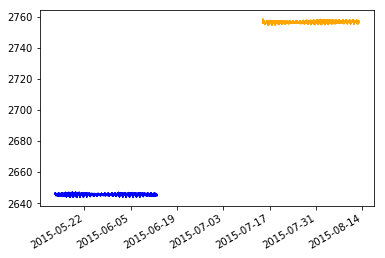

In [143]:
d0_df.plot(color='blue')
d1_df.plot(color='orange')
plt.show()

After.

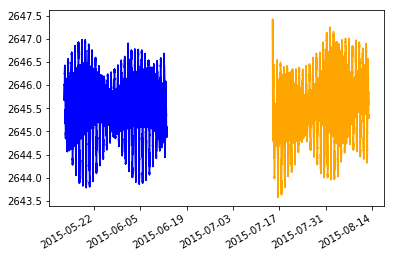

In [144]:
p_offset = ypred_d0_df_m[0] - ypred_d1_df_m[0]
d1_df_c = d1_df.to_frame()
d1_df_c['seawater_pressure_corrected'] = d1_df_c['seawater_pressure'] + p_offset
d0_df.plot(color='blue')
d1_df_c['seawater_pressure_corrected'].plot(color='orange')
plt.show()

In [145]:
print "predicted offset", p_offset

predicted offset -111.188923499
